In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import odeint

In [2]:
active_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

deaths_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

recovered_df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

active = active_df[active_df['Country/Region'] == 'China'].drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1).agg(sum)
deaths = deaths_df[deaths_df['Country/Region'] == 'China'].drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1).agg(sum)
recovered = recovered_df[recovered_df['Country/Region'] == 'China'].drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1).agg(sum)

df = pd.DataFrame({'total_active':active, 'total_deaths': deaths, 'total_recovered': recovered})
df['current_active'] = df.total_active.diff(1)
df = df.fillna(method = 'bfill')
df.head(2)

,total_active,total_deaths,total_recovered,current_active
1/22/20,548,17,28,95.0
1/23/20,643,18,30,95.0


#### SEIRD Model

Model structure available here: https://www.researchgate.net/figure/Schematic-of-the-SEIRD-model-ie-the-dynamics-of-Susceptible-Exposed-ie-latently_fig3_268227345

$ \beta$ : probability of transmitting a disease between a susceptible and an infectious person

$ \sigma $: incubation rate (rate at which exposed population becomes infected)

$ \gamma $: removal rate (rate at which people are removed from the infected population)

$f$: fraction of removed people who remain alive

$N$: total population


In [20]:
def model(z,t, beta, sigma, gamma, f, N):
    S = z[0]
    E = z[1]
    I = z[2]
    R = z[3]
    D = z[4]
    
    if (t<10):
        C = 1
        booster = 1
    else: 
        C = 0.04
        booster = np.exp(0.11*(t-3))
        
    dSdt = -C*beta*S*I/N 
    dEdt = C*beta*S*I/N - sigma*E
    dIdt = (sigma*E - gamma*I)
    dRdt = gamma*f*I*booster
    dDdt = gamma*(1-f)*I
    
    dzdt = (dSdt, dEdt, dIdt, dRdt, dDdt)
    return dzdt

In [21]:
# initial conditions
N = 58500000
E_0 = 0
I_0 = 95
R_0 = 28
D_0 = 17
S_0 = N - E_0 - I_0 - R_0 - D_0

z_0 = [S_0, E_0, I_0, R_0, D_0]

# time points
n = 500
t = np.linspace(0,n-1,n)

# solution matrices
S = np.empty_like(t)
E = np.empty_like(t)
I = np.empty_like(t)
R = np.empty_like(t)
D = np.empty_like(t)

S[0], E[0], I[0], R[0], D[0] = S_0, E_0, I_0, R_0, D_0

# set parameters
beta, sigma, gamma, f, N = (0.67066, 0.9, 0.091, 0.55, N)

# solve ODE
for i in range(1,n):
    tspan = [t[i-1], t[i]]
    z = odeint(model, z_0, tspan, args = (beta, sigma, gamma, f, N))
    S[i] = z[1][0]
    E[i] = z[1][1]
    I[i] = z[1][2]
    R[i] = z[1][3]
    D[i] = z[1][4]
    z_0 = z[1]

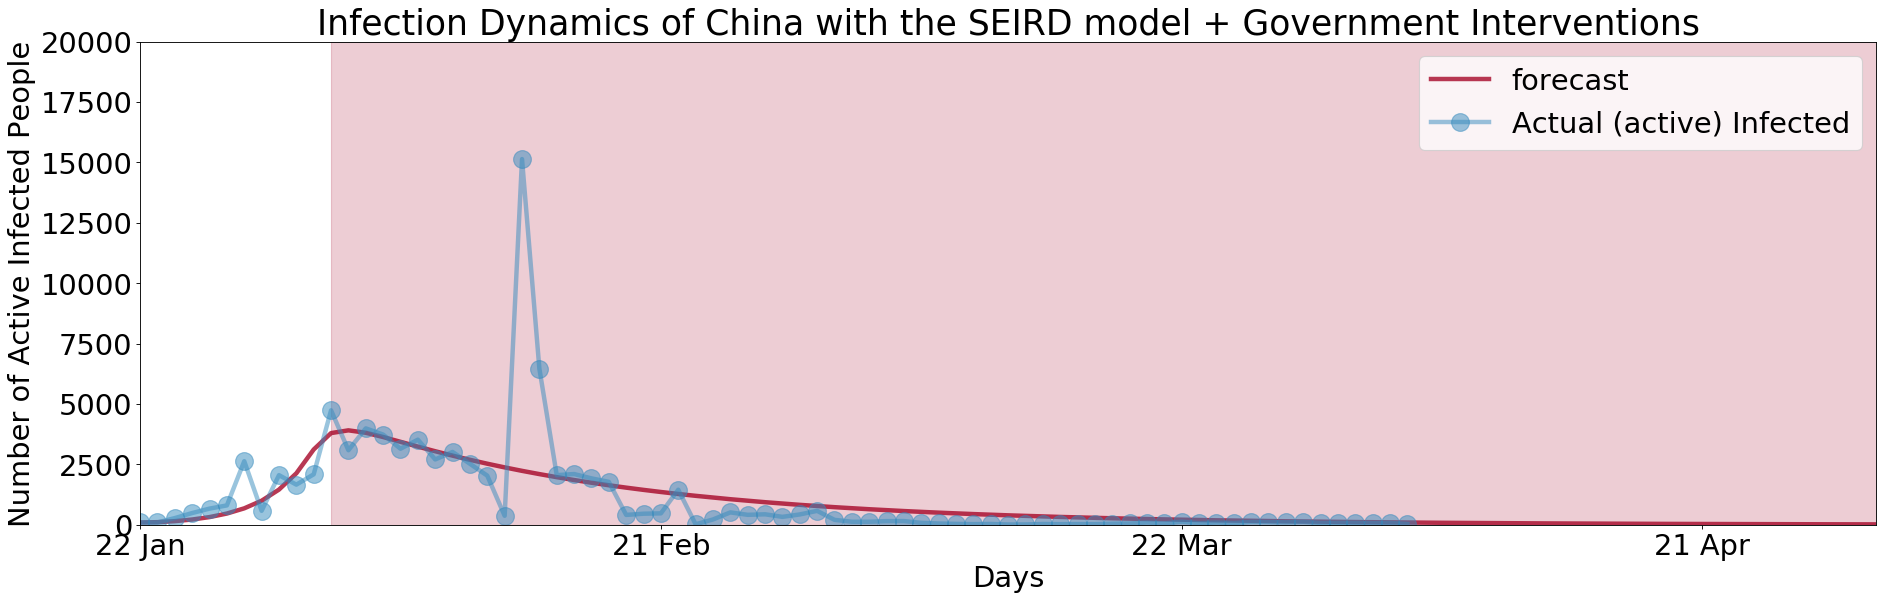

In [22]:
# plot resuts
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, I, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.fill_between(t[11:], 0, 160000, color="#A60628", alpha=0.2)
plt.plot(df.current_active, 'o-', lw=4, color='#348ABD', ms=16, label='Actual (active) Infected', alpha=0.5)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Active Infected People')
plt.title('Infection Dynamics of China with the SEIRD model + Government Interventions')
plt.xticks(np.array([0,30,60,90,120]),('22 Jan','21 Feb','22 Mar','21 Apr'))
plt.xlim([0,100]); plt.ylim([0,20000])
plt.show()

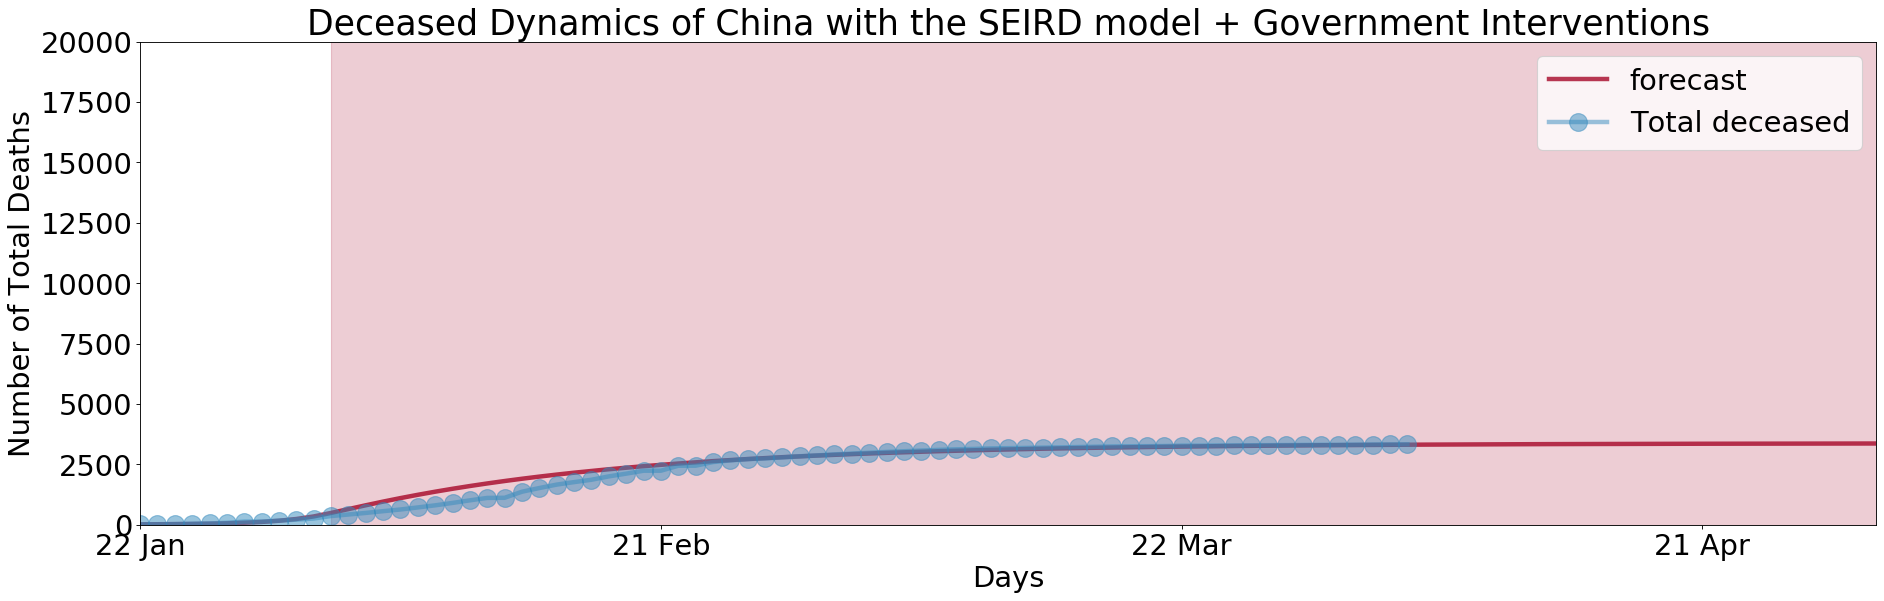

In [23]:
# plot resuts
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, D, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.fill_between(t[11:], 0, 160000, color="#A60628", alpha=0.2)
plt.plot(df.total_deaths, 'o-', lw=4, color='#348ABD', ms=16, label='Total deceased', alpha=0.5)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Total Deaths')
plt.title('Deceased Dynamics of China with the SEIRD model + Government Interventions')
plt.xticks(np.array([0,30,60,90,120]),('22 Jan','21 Feb','22 Mar','21 Apr'))
plt.xlim([0,100]); plt.ylim([0,20000])
plt.show()

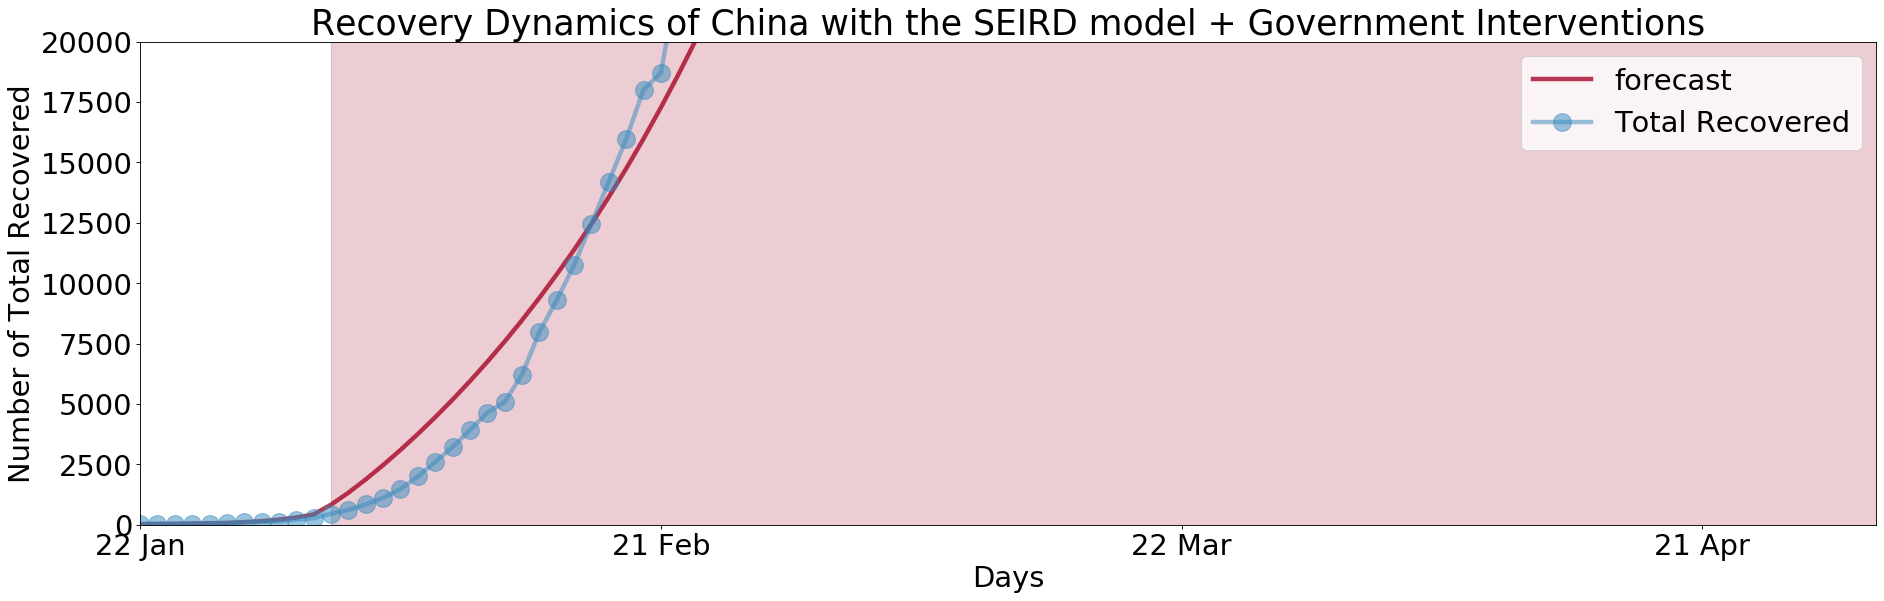

In [26]:
# plot resuts
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 26})

plt.plot(t, R, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.fill_between(t[11:], 0, 160000, color="#A60628", alpha=0.2)
plt.plot(df.total_recovered, 'o-', lw=4, color='#348ABD', ms=16, label='Total Recovered', alpha=0.5)
plt.legend()
plt.xlabel('Days')
plt.ylabel('Number of Total Recovered')
plt.title('Recovery Dynamics of China with the SEIRD model + Government Interventions')
plt.xticks(np.array([0,30,60,90,120]),('22 Jan','21 Feb','22 Mar','21 Apr'))
plt.xlim([0,100]); plt.ylim([0,20000])
plt.show()